##### Figure 09
# CONUS 95th percentile wind occurrence

In [1]:
%matplotlib inline
import h5py
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
from mpl_toolkits.basemap import Basemap

import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v2')
from BB_downloads.HRRR_S3 import *
from BB_wx_calcs.wind import wind_uv_to_spd
from BB_basemap.draw_maps import draw_CONUS_HRRR_map
from BB_MesoWest.MesoWest_STNinfo import get_MW_location_dict
from BB_MesoWest.MesoWest_timeseries import get_mesowest_ts
from BB_MesoWest.MesoWest_nearesttime import get_mesowest_nearesttime
from BB_MesoWest.MesoWest_percentiles import get_mesowest_percentiles
from BB_data.grid_manager import pluck_point_new
from BB_wx_calcs.wind import wind_uv_to_spd

In [227]:
from matplotlib.dates import DateFormatter
formatter = DateFormatter('%b')

import matplotlib as mpl 
two_column = 5.5
one_column = 3.2
twothird_column = 6.8
mpl.rcParams['figure.figsize'] = [6.9, 9.3]
mpl.rcParams['figure.titlesize'] = 12
mpl.rcParams['figure.titleweight'] = 'bold'
mpl.rcParams['xtick.labelsize'] = 8
mpl.rcParams['ytick.labelsize'] = 8
mpl.rcParams['axes.labelsize'] = 8
mpl.rcParams['axes.titlesize'] = 10
mpl.rcParams['lines.linewidth'] = 1.8
mpl.rcParams['grid.linewidth'] = .25
mpl.rcParams['figure.subplot.wspace'] = 0.03
mpl.rcParams['figure.subplot.hspace'] = 0.03
mpl.rcParams['legend.fontsize'] = 7
mpl.rcParams['legend.framealpha'] = .75
mpl.rcParams['legend.loc'] = 'best'
mpl.rcParams['savefig.bbox'] = 'tight'
    
mpl.rcParams['savefig.dpi'] = 600    # 600 for print

--------------

In [15]:
# Get Lat/Lon Grid
DIR = '/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/'
latlon_file = h5py.File(DIR+'OSG_HRRR_latlon.h5', 'r')
lat = latlon_file['latitude'].value
lon = latlon_file['longitude'].value

In [85]:
m = draw_CONUS_HRRR_map(res='i', area_thresh=10000)

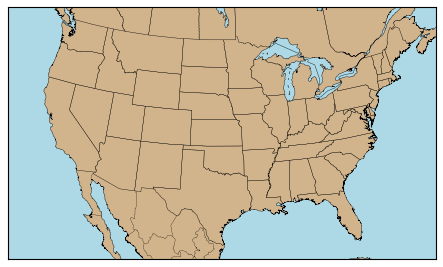

In [188]:
def set_up_map():
    m.drawcountries(linewidth=.35, zorder=500)
    m.drawstates(linewidth=.25, zorder=500)
    m.drawcoastlines(linewidth=.35, zorder=500)
    m.fillcontinents(color='tan',lake_color='lightblue', zorder=0)
    m.drawmapboundary(fill_color='lightblue')

set_up_map()

---------

In [189]:
def plot_500mb(VALIDDATE, fxx):
    RUNDATE = VALIDDATE - timedelta(hours=fxx)
    H_500 = get_hrrr_variable(RUNDATE, 'HGT:500 mb',
                              fxx=fxx,
                              outDIR='/uufs/chpc.utah.edu/common/home/u0553130/temp/',
                              verbose=False)

    CS = m.contour(lon, lat, H_500['value'], 
                    levels=range(5040, 6181, 60),
                    linewidths=.85,
                    colors='k', 
                    latlon=True,
                    zorder=400)
    plt.clabel(CS, inline=1, fmt='%2.f', fontsize=7)
    return CS

In [199]:
def plot_TMP(VALIDDATE, fxx):
    RUNDATE = VALIDDATE - timedelta(hours=fxx)
    H_tmp = get_hrrr_variable(RUNDATE, 'TMP:2 m',
                              fxx=fxx,
                              outDIR='/uufs/chpc.utah.edu/common/home/u0553130/temp/',
                              verbose=False)
    
    DIR = '/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/hourly30/TMP_2_m/'
    FILE = 'OSG_HRRR_%s_m%02d_d%02d_h%02d_f00.h5' % (('TMP_2_m', VALIDDATE.month, VALIDDATE.day, VALIDDATE.hour))

    ### Plot Temperature Depression
    with h5py.File(DIR+FILE, 'r') as f:
        tmp_p05 = f["p05"][:]
    masked = H_tmp['value']-tmp_p05 # both these datasets are in Kelvin, but when we take the difference it is in Celsius
    masked = np.ma.array(masked)
    masked[masked > 0] = np.ma.masked
    
    mesh_depression = m.pcolormesh(lon, lat, masked,
                                   vmax=10, vmin=-10,
                                   latlon=True,
                                   cmap='bwr')
    
    ### Plot Temperature Exceedance
    with h5py.File(DIR+FILE, 'r') as f:
        tmp_p95 = f["p95"][:]
    masked = H_tmp['value']-tmp_p95 # both these datasets are in Kelvin, but when we take the difference it is in Celsius
    masked = np.ma.array(masked)
    masked[masked < 0] = np.ma.masked

    mesh_exceedance = m.pcolormesh(lon, lat, masked,
                                   vmax=10, vmin=-10,
                                   latlon=True,
                                   cmap='bwr')
    
    return [mesh_exceedance, mesh_depression]

In [197]:
def plot_DPT(VALIDDATE, fxx):
    RUNDATE = VALIDDATE - timedelta(hours=fxx)
    H_dpt = get_hrrr_variable(RUNDATE, 'DPT:2 m',
                              fxx=fxx,
                              outDIR='/uufs/chpc.utah.edu/common/home/u0553130/temp/',
                              verbose=False)
    
    DIR = '/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/hourly30/DPT_2_m/'
    FILE = 'OSG_HRRR_%s_m%02d_d%02d_h%02d_f00.h5' % (('DPT_2_m', VALIDDATE.month, VALIDDATE.day, VALIDDATE.hour))

    ### Plot Dew Point Depression
    with h5py.File(DIR+FILE, 'r') as f:
        dpt_p05 = f["p05"][:]
    masked = H_dpt['value']-dpt_p05 # both these datasets are in Kelvin, but when we take the difference it is in Celsius
    masked = np.ma.array(masked)
    masked[masked > 0] = np.ma.masked
    
    mesh_depression = m.pcolormesh(lon, lat, masked,
                                   vmax=10, vmin=-10,
                                   latlon=True,
                                   cmap='BrBG')
    
    ### Plot Dew Point Exceedance
    with h5py.File(DIR+FILE, 'r') as f:
        dpt_p95 = f["p95"][:]
    masked = H_dpt['value']-dpt_p95 # both these datasets are in Kelvin, but when we take the difference it is in Celsius
    masked = np.ma.array(masked)
    masked[masked < 0] = np.ma.masked

    mesh_exceedance = m.pcolormesh(lon, lat, masked,
                                   vmax=10, vmin=-10,
                                   latlon=True,
                                   cmap='BrBG')
    
    return [mesh_exceedance, mesh_depression]

In [166]:
def plot_UVGRD_p95_exceedance(VALIDDATE, fxx):
    RUNDATE = VALIDDATE - timedelta(hours=fxx)
    H_u = get_hrrr_variable(RUNDATE, 'UGRD:10 m',
                            fxx=fxx,
                            outDIR='/uufs/chpc.utah.edu/common/home/u0553130/temp/',
                            verbose=False, value_only=True)
    H_v = get_hrrr_variable(RUNDATE, 'VGRD:10 m',
                            fxx=fxx,
                            outDIR='/uufs/chpc.utah.edu/common/home/u0553130/temp/',
                            verbose=False, value_only=True)
    spd = wind_uv_to_spd(H_u['value'], H_v['value'])
    
    DIR = '/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/hourly30/UVGRD_10_m/'
    FILE = 'OSG_HRRR_%s_m%02d_d%02d_h%02d_f00.h5' % (('UVGRD_10_m', VALIDDATE.month, VALIDDATE.day, VALIDDATE.hour))

    with h5py.File(DIR+FILE, 'r') as f:
        wind_p95 = f["p95"][:]
    masked = spd-wind_p95 # both these datasets are in Kelvin, but when we take the difference it is in Celsius
    masked = np.ma.array(masked)
    masked[masked < 0] = np.ma.masked

    mesh = m.pcolormesh(lon, lat, masked,
                        vmax=10, vmin=0,
                        latlon=True,
                        cmap='viridis')
    return mesh

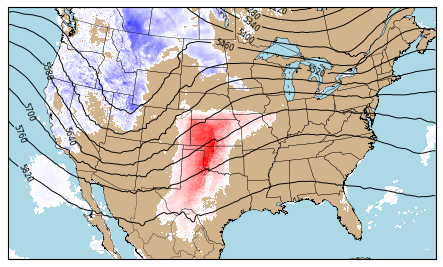

In [201]:
set_up_map()
plot_500mb(VALIDDATE, fxx)
PC = plot_TMP(VALIDDATE, fxx)

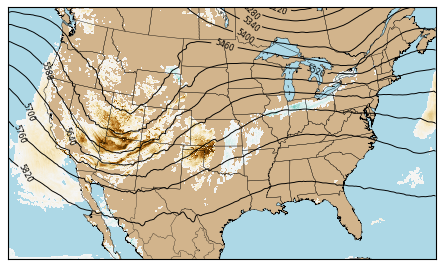

In [198]:
set_up_map()
plot_500mb(VALIDDATE, fxx)
PC = plot_DPT(VALIDDATE, fxx)

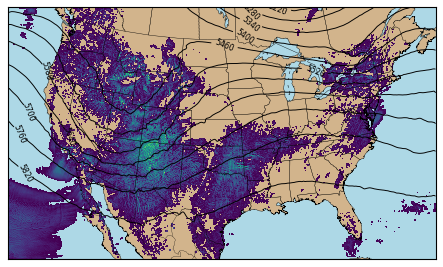

In [192]:
set_up_map()
plot_500mb(VALIDDATE, fxx)
PC = plot_UVGRD_p95_exceedance(VALIDDATE, fxx)

In [83]:
VALIDDATE = datetime(2018, 4, 13, 0)
VALIDDATE2 = datetime(2018, 4, 13, 15)
fxx = 18

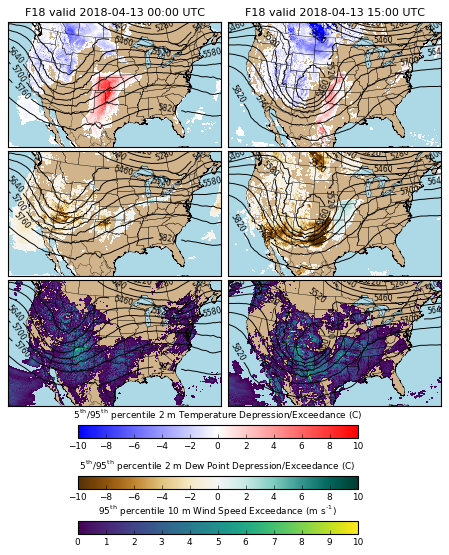

In [239]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=[7,8])

plt.sca(ax1)
set_up_map()
plot_500mb(VALIDDATE, fxx)
TMP = plot_TMP(VALIDDATE, fxx)
plt.title('F%02d valid %s' % (fxx, VALIDDATE.strftime('%Y-%m-%d %H:%M UTC')))

plt.sca(ax2)
set_up_map()
plot_500mb(VALIDDATE2, fxx)
plot_TMP(VALIDDATE2, fxx)
plt.title('F%02d valid %s' % (fxx, VALIDDATE2.strftime('%Y-%m-%d %H:%M UTC')))

plt.sca(ax3)
set_up_map()
plot_500mb(VALIDDATE, fxx)
DPT = plot_DPT(VALIDDATE, fxx)

plt.sca(ax4)
set_up_map()
plot_500mb(VALIDDATE2, fxx)
plot_DPT(VALIDDATE2, fxx)

plt.sca(ax5)
set_up_map()
plot_500mb(VALIDDATE, fxx)
UVGRD = plot_UVGRD_p95_exceedance(VALIDDATE, fxx)

plt.sca(ax6)
set_up_map()
plot_500mb(VALIDDATE2, fxx)
plot_UVGRD_p95_exceedance(VALIDDATE2, fxx)

fig.subplots_adjust(bottom=0.3)
cbar_ax = fig.add_axes([0.25, 0.25, 0.5, 0.02]) # [left, bottom, width, height]
cb = fig.colorbar(TMP[0], cax=cbar_ax, ticks=range(-10,11,2), orientation='horizontal')
cb.ax.set_xlabel(r'5$\mathregular{^{th}}$/95$\mathregular{^{th}}$ percentile 2 m Temperature Depression/Exceedance (C)')
cb.ax.xaxis.set_label_position('top')

cbar_ax = fig.add_axes([0.25, 0.17, 0.5, 0.02]) # [left, bottom, width, height]
cb = fig.colorbar(DPT[0], cax=cbar_ax, ticks=range(-10,11,2), orientation='horizontal')
cb.ax.set_xlabel(r'5$\mathregular{^{th}}$/95$\mathregular{^{th}}$ percentile 2 m Dew Point Depression/Exceedance (C)')
cb.ax.xaxis.set_label_position('top')

cbar_ax = fig.add_axes([0.25, 0.1, 0.5, 0.02]) # [left, bottom, width, height]
cb = fig.colorbar(UVGRD, cax=cbar_ax, ticks=range(-10,11,1), orientation='horizontal')
cb.ax.set_xlabel(r'95$\mathregular{^{th}}$ percentile 10 m Wind Speed Exceedance (m s$\mathregular{^{-1}}$)')
cb.ax.xaxis.set_label_position('top')

plt.savefig('./figs/Fig_09_CONUS_Oklahoma_case')